In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_io as tfio

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
os.getcwd()

'C:\\Users\\kesha\\Desktop\\Projects\\Voice Command Recognition'

In [3]:
SAMPLING_RATE = 16000
SCALE = 0.5
BATCH_SIZE = 32

In [4]:
# Import the Speech Commands dataset
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file(
    'mini_speech_commands.zip',
    origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
    extract=True,
    cache_dir='.', cache_subdir='data')
    
# Check basic statistics about the dataset.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [5]:
# Extract the audio files into a list and shuffle it.
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data\\mini_speech_commands\\up\\b7a6f709_nohash_0.wav', shape=(), dtype=string)


In [6]:
# Split the files into training, validation and test sets using a 80:10:10 ratio, respectively.
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [7]:
"""
Noise preparation
In this section:

We load all noise samples (which should have been resampled to 16000)
We split those noise samples to chunks of 16000 samples which correspond to 1 second duration each
"""

DATASET_NOISE_PATH = str(pathlib.Path('data/noise'))
print(DATASET_NOISE_PATH)

# Get the list of all noise files
noise_paths = []
for subdir in os.listdir(DATASET_NOISE_PATH):
    subdir_path = pathlib.Path(DATASET_NOISE_PATH) / subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]

print(
    "Found {} files belonging to {} directories".format(
        len(noise_paths), len(os.listdir(DATASET_NOISE_PATH))
    )
)

data\noise
Found 6 files belonging to 2 directories


In [8]:
command = (
    "for dir in `ls -1 " + DATASET_NOISE_PATH + "`; do "
    "for file in `ls -1 " + DATASET_NOISE_PATH + "/$dir/*.wav`; do "
    "sample_rate=`ffprobe -hide_banner -loglevel panic -show_streams "
    "$file | grep sample_rate | cut -f2 -d=`; "
    "if [ $sample_rate -ne 16000 ]; then "
    "ffmpeg -hide_banner -loglevel panic -y "
    "-i $file -ar 16000 temp.wav; "
    "mv temp.wav $file; "
    "fi; done; done"
)

os.system(command)

1

In [9]:
def load_noise_sample(path):
    sample, sampling_rate = tf.audio.decode_wav(
        tf.io.read_file(path), desired_channels=1
    )
    if sampling_rate == SAMPLING_RATE:
        # Number of slices of 16000 each that can be generated from the noise sample
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample
    else:
        sample = tfio.audio.resample(sample, sampling_rate.numpy(), SAMPLING_RATE)
        slices = int(sample.shape[0] / SAMPLING_RATE)
        sample = tf.split(sample[: slices * SAMPLING_RATE], slices)
        return sample

noises = []
for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)
noises = tf.stack(noises)

print(
    "{} noise files were split into {} noise samples where each is {} sec. long".format(
        len(noise_paths), noises.shape[0], noises.shape[1] // SAMPLING_RATE
    )
)

6 noise files were split into 354 noise samples where each is 1 sec. long


In [10]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    # Note: You'll use indexing here instead of tuple unpacking to enable this 
    # to work in a TensorFlow graph.
    label_id = tf.argmax(parts[-2] == commands)
    return label_id

def paths_and_labels_to_dataset(audio_paths):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = path_ds.map(lambda x: get_label(x))
#     label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))


def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio

def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        # Create a random tensor of the same size as audio ranging from
        # 0 to the number of noise stream samples that we have.
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype=tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)

        # Get the amplitude proportion between the audio and the noise
        prop = tf.math.reduce_max(audio, axis=1) / tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        # Adding the rescaled noise to audio
        audio = audio + noise * prop * scale

    return audio

def get_spectrogram(waveform):
    waveform = tf.squeeze(waveform, axis=-1)
    
    spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)

    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, -1)

    return spectrogram

In [11]:
train_ds = paths_and_labels_to_dataset(train_files)
train_ds

<ZipDataset shapes: ((16000, 1), ()), types: (tf.float32, tf.int64)>

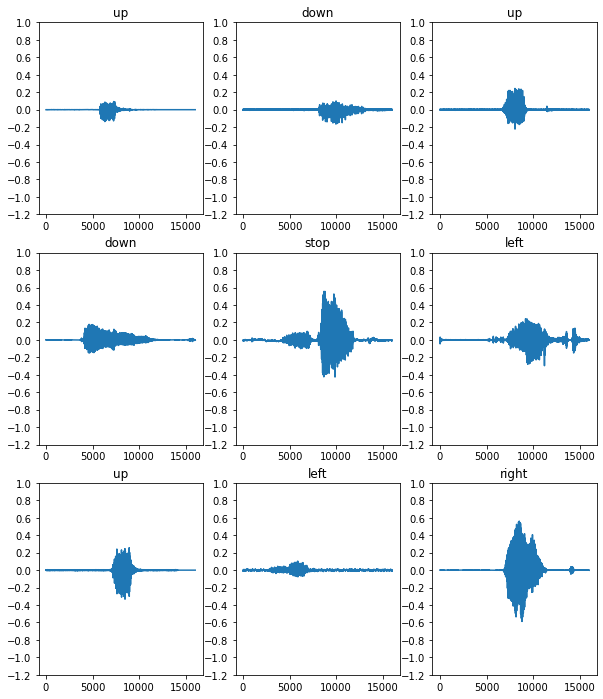

In [12]:
# Let's examine a few audio waveforms with their corresponding labels.

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(train_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = commands[label.numpy()]
    ax.set_title(label)

plt.show()

In [13]:
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=123).batch(
    BATCH_SIZE
)
train_ds

<BatchDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int64)>

In [14]:
# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=SCALE), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)
train_ds

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


<ParallelMapDataset shapes: ((None, 16000, 1), (None,)), types: (tf.float32, tf.int64)>

## Spectrogram With Noise Included

You'll convert the waveform into a spectrogram, which shows frequency changes over time and can be represented as a 2D image. This can be done by applying the short-time Fourier transform (STFT) to convert the audio into the time-frequency domain.

A Fourier transform (tf.signal.fft) converts a signal to its component frequencies, but loses all time information. The STFT (tf.signal.stft) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

STFT produces an array of complex numbers representing magnitude and phase. However, you'll only need the magnitude for this tutorial, which can be derived by applying tf.abs on the output of tf.signal.stft.

Choose frame_length and frame_step parameters such that the generated spectrogram "image" is almost square. For more information on STFT parameters choice, you can refer to this video on audio signal processing.

You also want the waveforms to have the same length, so that when you convert it to a spectrogram image, the results will have similar dimensions. This can be done by simply zero padding the audio clips that are shorter than one second.

In [15]:
for audio, label in train_ds.take(1):
    print(audio.shape)
    print(label.shape)

(32, 16000, 1)
(32,)


In [17]:
tf.squeeze(get_spectrogram(audio[0]),-1)

<tf.Tensor: shape=(124, 129), dtype=float32, numpy=
array([[1.91926926e-01, 8.35532486e-01, 1.93227375e+00, ...,
        1.03165745e-04, 1.21205034e-04, 3.07932496e-05],
       [6.28867269e-01, 1.73103595e+00, 3.09945750e+00, ...,
        5.29066347e-05, 3.77656943e-05, 9.87649037e-05],
       [3.99979889e-01, 5.85740507e-01, 1.12298799e+00, ...,
        8.17073451e-05, 4.33507466e-06, 5.05000316e-05],
       ...,
       [2.21012488e-01, 1.86353219e+00, 2.15136433e+00, ...,
        1.55303151e-05, 1.02762106e-05, 2.99513317e-06],
       [8.86100411e-01, 2.24308753e+00, 2.43223906e+00, ...,
        6.55381809e-05, 4.70410523e-05, 4.11868095e-05],
       [2.49421626e-01, 2.07185340e+00, 2.23395634e+00, ...,
        4.46228660e-05, 8.02363593e-06, 1.46776456e-05]], dtype=float32)>

In [19]:
"Listen to audio with noise included"

for audio, label in train_ds.take(1):
    waveform = tf.squeeze(audio[0], -1)
    label = commands[label[0].numpy()]
    spectrogram = tf.squeeze(get_spectrogram(audio[0]), -1)

print('Label:', label)
print('Waveform shape:', audio.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: right
Waveform shape: (32, 16000, 1)
Spectrogram shape: (124, 129)
Audio playback


<ipython-input-20-544266338ef3>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)


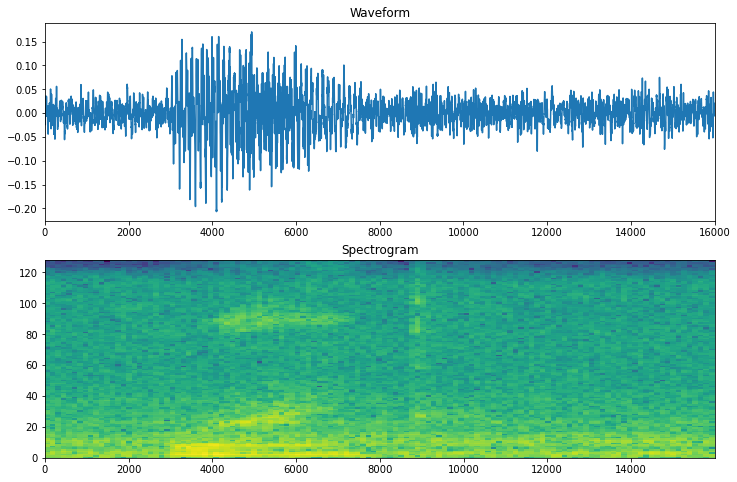

In [20]:
"Plot of Spectrogram with Noise"

def plot_spectrogram(spectrogram, ax):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [21]:
# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (get_spectrogram(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)
train_ds

<ParallelMapDataset shapes: ((None, 124, 129, 1), (None,)), types: (tf.float32, tf.int64)>

In [22]:
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [23]:
for audio, label in train_ds.take(1):
    print(audio.shape[1:])

(124, 129, 1)


<ipython-input-20-544266338ef3>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(X, Y, log_spec)
<ipython-input-20-544266338ef3>:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


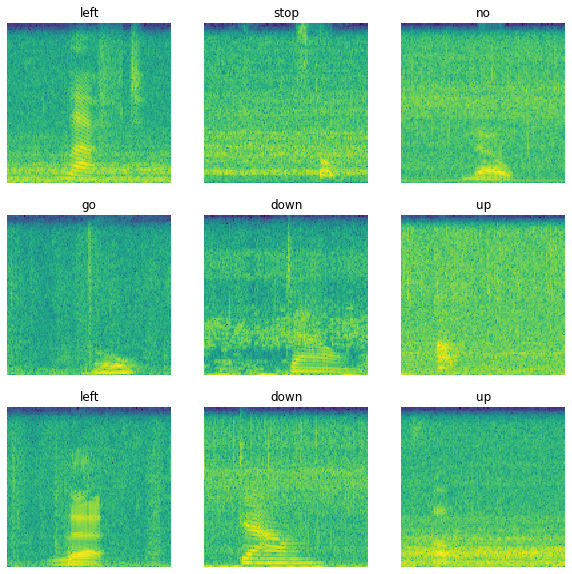

In [29]:
# Examine the spectrogram "images" for different samples of the dataset.
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(1)):
    for j in range(0,n):
        r = j // cols
        c = j % cols
        ax = axes[r][c]
        plot_spectrogram(np.squeeze(spectrogram[j].numpy()), ax)
        ax.set_title(commands[label_id[j].numpy()])
        ax.axis('off')

plt.show()

## Build and train the model

Now you can build and train your model. But before you do that, you'll need to repeat the training set preprocessing on the validation and test sets.

In [30]:
def preprocess_dataset(files, include_noise=False):
    files_ds = paths_and_labels_to_dataset(files)
    files_ds = files_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=123).batch(BATCH_SIZE)
    if include_noise:
        files_ds = files_ds.map(
            lambda x, y: (add_noise(x, noises, scale=SCALE), y),
            num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
    files_ds = files_ds.map(
        lambda x, y: (get_spectrogram(x), y), 
        num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    files_ds = files_ds.prefetch(tf.data.experimental.AUTOTUNE)
    return files_ds

In [31]:
val_ds = preprocess_dataset(val_files, include_noise=True)
test_ds = preprocess_dataset(test_files, include_noise=False)

For the model, we'll use a custom residual CNN neural network, since we have transformed the audio files into spectrogram images. The model also has the following additional preprocessing layers:

    1. A Resizing layer to downsample the input to enable the model to train faster.
    2. A Normalization layer to normalize each pixel in the image based on its mean and standard deviation.

For the Normalization layer, its adapt method would first need to be called on the training data in order to compute aggregate statistics (i.e. mean and standard deviation).

In [33]:
"Model Definition"

def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = layers.Conv2D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.Activation(activation)(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([x, s])
    x = layers.Activation(activation)(x)
    return layers.MaxPool2D(pool_size=2, strides=2)(x)

for spectrogram, _ in train_ds.take(1):
    input_shape = spectrogram.shape[1:]
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: x))

def build_model(input_shape, num_labels):
    inputs = layers.Input(shape=input_shape, name="input")
    x = preprocessing.Resizing(128, 128)(inputs)
    x = norm_layer(x)
    
    x = residual_block(x, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
#     x = residual_block(x, 128, 3)

# #     x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dense(128, activation="relu")(x)

    outputs = layers.Dense(num_labels, activation="linear", name="output")(x)

    return models.Model(inputs=inputs, outputs=outputs)

model = build_model(input_shape, num_labels)
print(model.summary())

Input shape: (124, 129, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 124, 129, 1) 0                                            
__________________________________________________________________________________________________
resizing_1 (Resizing)           (None, 128, 128, 1)  0           input[0][0]                      
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 128, 128, 1)  3           resizing_1[0][0]                 
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 16) 160         normalization_1[0][0]            
_________________________________________________________________

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [35]:
# With Noise
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
200/200 [==============================] - 54s 164ms/step - loss: 1.8074 - accuracy: 0.3028 - val_loss: 1.1528 - val_accuracy: 0.5938
Epoch 2/10
200/200 [==============================] - 27s 133ms/step - loss: 0.8834 - accuracy: 0.6861 - val_loss: 0.7037 - val_accuracy: 0.7563
Epoch 3/10
200/200 [==============================] - 27s 133ms/step - loss: 0.5525 - accuracy: 0.8114 - val_loss: 0.4605 - val_accuracy: 0.8388
Epoch 4/10
200/200 [==============================] - 27s 134ms/step - loss: 0.4074 - accuracy: 0.8617 - val_loss: 0.4823 - val_accuracy: 0.8525
Epoch 5/10
200/200 [==============================] - 27s 133ms/step - loss: 0.3432 - accuracy: 0.8842 - val_loss: 0.3570 - val_accuracy: 0.8775
Epoch 6/10
200/200 [==============================] - 27s 134ms/step - loss: 0.2979 - accuracy: 0.8956 - val_loss: 0.2929 - val_accuracy: 0.9013
Epoch 7/10
200/200 [==============================] - 27s 134ms/step - loss: 0.2554 - accuracy: 0.9120 - val_loss: 0.3295 - val_ac

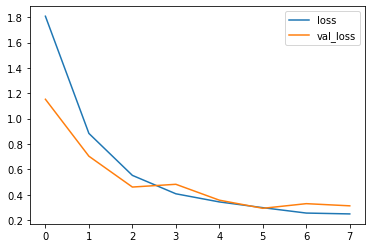

In [36]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate test set performance

Let's run the model on the test set and check performance.

In [37]:
test_audio = []
test_labels = []

for audio, label in test_ds.unbatch():
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [38]:
test_audio.shape

(800, 124, 129, 1)

In [39]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 94%


## Display a confusion matrix

A confusion matrix is helpful to see how well the model did on each of the commands in the test set.

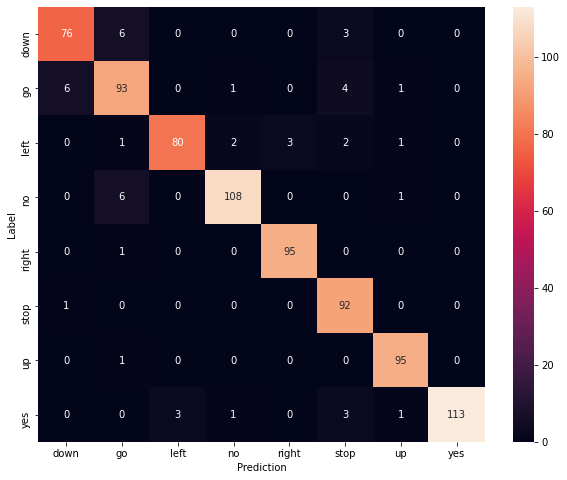

In [40]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no." How well does your model perform?

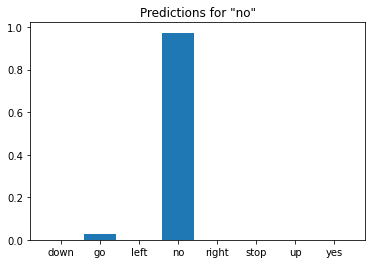

In [44]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.take(1):
    
    prediction = model(spectrogram)
    plt.bar(commands, tf.nn.softmax(prediction[0]))
    plt.title(f'Predictions for "{commands[label[0]]}"')
    plt.show()